## Function that generates the training data

In [1528]:
from tqdm import tqdm
import numpy as np
from skimage.filters import gaussian
def generateTrainingData(noise_factor, data, labels):

    noise_factors = []
    current_noise = 0
    while current_noise < 1:
         noise_factors.append(current_noise)
         current_noise += noise_factor

    x = []
    y = []
    z = []
    
    sampled_data = data.copy()
    sampled_labels = labels.copy()

    last_noise = None
    hasLast = False

    noise = np.random.rand(sampled_data.shape[0], 28*28) 

    for current_noise in tqdm(noise_factors):
        cx = np.empty(sampled_data.shape)
        cx = (sampled_data / 255).astype('float32')
        for i in range(len(sampled_data)):
            cx[i] = gaussian(cx[i], sigma=current_noise*10)
        
        cx = cx.reshape(len(cx), 28 * 28)

        cx = cx.copy()
        cx = cx * (1-current_noise) + current_noise  * noise # * np.random.rand(cx.shape[0], cx.shape[1]) #
        cx = np.clip(cx, 0., 1.)


        if hasLast:
            x.append(cx)
            y.append(last_noise)
            z.append(sampled_labels)

        last_noise = cx

        hasLast = True

       
    x.reverse()
    y.reverse()
    z.reverse()
    return (x, y, z)

## Loading mnist dataset and processing it

In [1529]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

from keras.utils import to_categorical

(x_train, y_train), (x_test, y_test) = mnist.load_data()

noise_factor = 1/5

x_train, y_train, l_train = generateTrainingData(noise_factor, x_train, y_train)
x_test, y_test, l_test = generateTrainingData(noise_factor, x_test, y_test)

l_train = to_categorical(l_train, num_classes=10)
l_test = to_categorical(l_test, num_classes=10)


100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


# Here is how each layer group training data looks like

[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


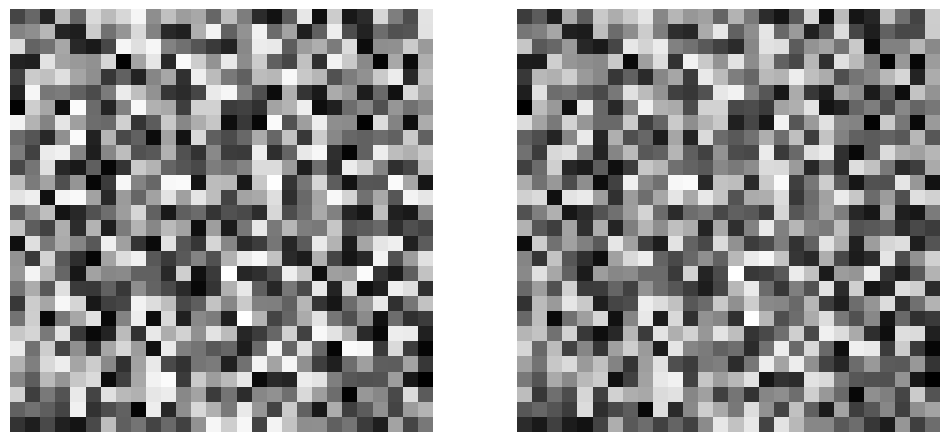

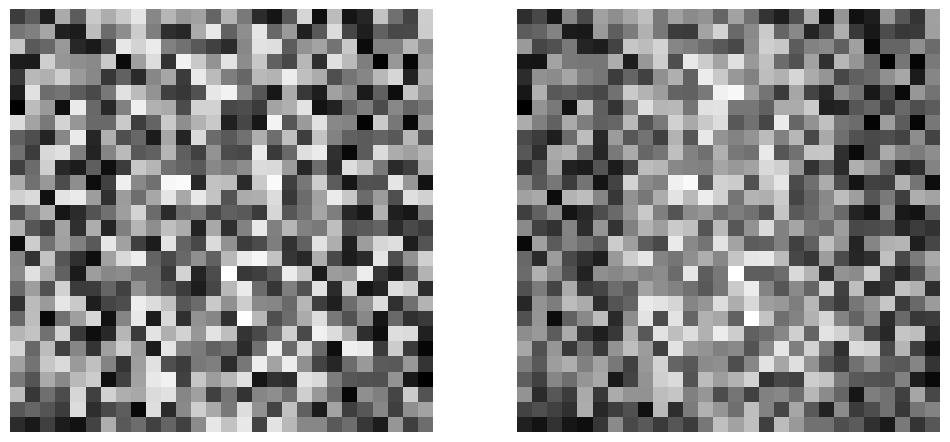

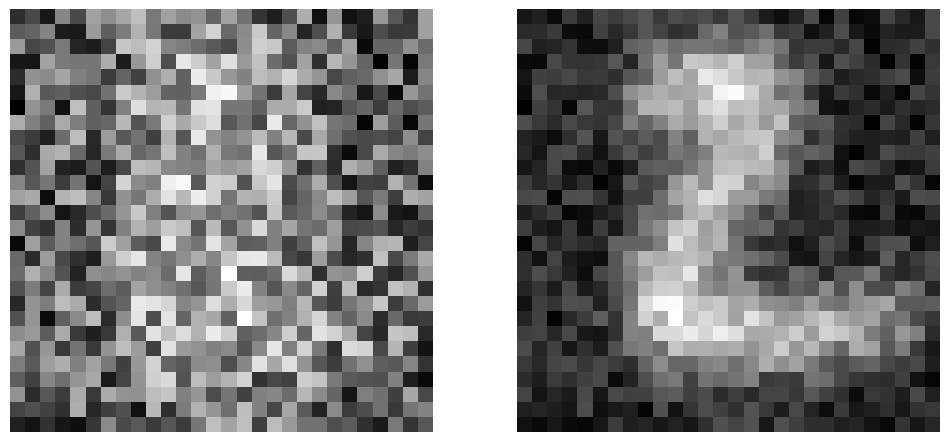

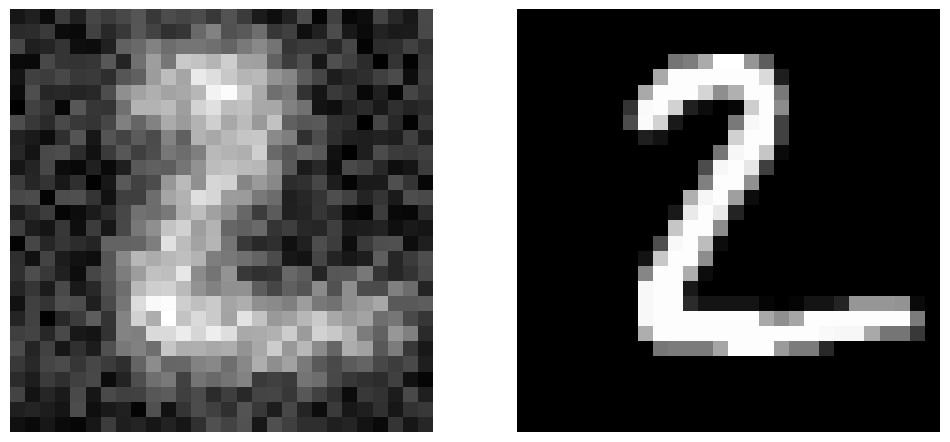

In [1530]:
import matplotlib.pyplot as plt

item = 1

for level in range(len(x_test)):

    fig, axs = plt.subplots(1,2, figsize=(12, 6), squeeze=False)
    axs[0, 0].imshow(x_test[level][item].reshape(28,28).astype('float'), cmap='gray')
    axs[0, 1].imshow(y_test[level][item].reshape(28,28).astype('float'), cmap='gray')
    for ax in axs[0]:
        ax.axis('off')

print(l_test[level][1])

## Training each group separately

In [1552]:
import numpy as np
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

from keras import layers, models

def layerGroup():
    noise_input = layers.Input(shape=(28 * 28,))
    label_input = layers.Input(shape=(10,))  

    concatenated_input = layers.concatenate([noise_input, label_input])

    x = layers.Dense(28*28, activation='relu')(concatenated_input)
    x = layers.Dense(28*28, activation='relu')(x)
    generated_image = layers.Dense(28*28)(x)

    model = models.Model(inputs=[noise_input, label_input], outputs=generated_image)

    model.compile(optimizer='adam', loss='mse')  

    return model

chunks = []
for i in tqdm(range(len(x_test))):
    current = layerGroup()
    current.fit([x_train[i],l_train[i]], y_train[i], epochs=10, batch_size=128,verbose=False)  
    chunks.append(current)



100%|██████████| 4/4 [00:28<00:00,  7.02s/it]


## Joining them into a single model for convenience

In [1553]:
def finalModel(chunks):
    noise_input = layers.Input(shape=(28 * 28,))
    label_input = layers.Input(shape=(10,))  # Assuming 10 classes for digits 0-9

    # Concatenate noise input with label
    x = None

    for chunk in chunks:
        if x == None:
            x = layers.concatenate([noise_input, label_input])
        else:
            x = layers.concatenate([x, label_input])
            
        x = layers.Dense(28*28, activation='relu')(x)
        x = layers.Dense(28*28, activation='relu')(x)
        x = layers.Dense(28*28)(x)

    model = models.Model(inputs=[noise_input, label_input], outputs=x)

    model.compile(optimizer='adam', loss='mse')  # Use appropriate loss function

    for i in range(len(chunks)):
        index = i*4
        model.layers[index+3].set_weights(chunks[i].layers[3].get_weights())
        model.layers[index+4].set_weights(chunks[i].layers[4].get_weights())
        model.layers[index+5].set_weights(chunks[i].layers[5].get_weights())

    return model

model = finalModel(chunks)
model.summary()

Model: "model_87"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_175 (InputLayer)         [(None, 784)]        0           []                               
                                                                                                  
 input_176 (InputLayer)         [(None, 10)]         0           []                               
                                                                                                  
 concatenate_132 (Concatenate)  (None, 794)          0           ['input_175[0][0]',              
                                                                  'input_176[0][0]']              
                                                                                                  
 dense_396 (Dense)              (None, 784)          623280      ['concatenate_132[0][0]'] 

## Save the model

In [1554]:
# model.save_weights("split-distillation/split-distillation")
# model.load_weights("split-distilaiton/ssplit-distillation")

# model.save("diffusion-checkpoint-10-epochs")

INFO:tensorflow:Assets written to: diffusion-checkpoint-10-epochs\assets


## Load the saved model

In [1557]:
import tensorflow as tf
model = tf.keras.models.load_model("diffusion-checkpoint-100-epochs")

In [1555]:
import tensorflow as tf
model = tf.keras.models.load_model("diffusion-checkpoint-10-epochs")

## Generate a few images

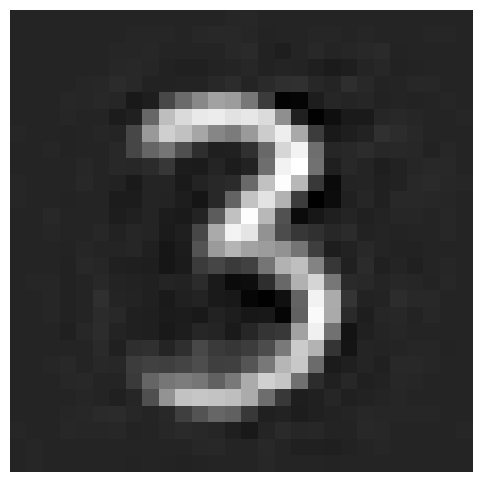

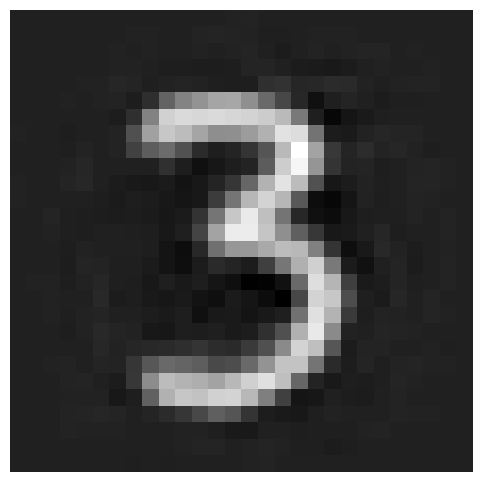

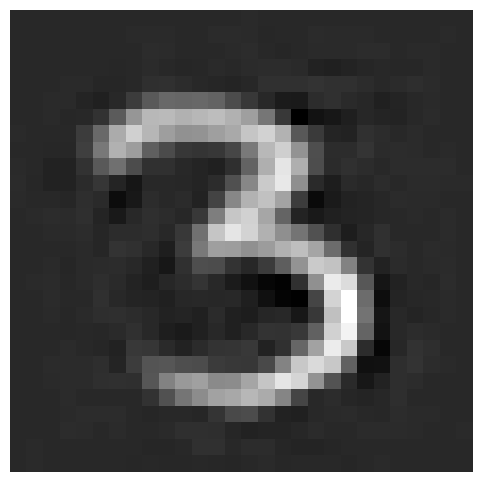

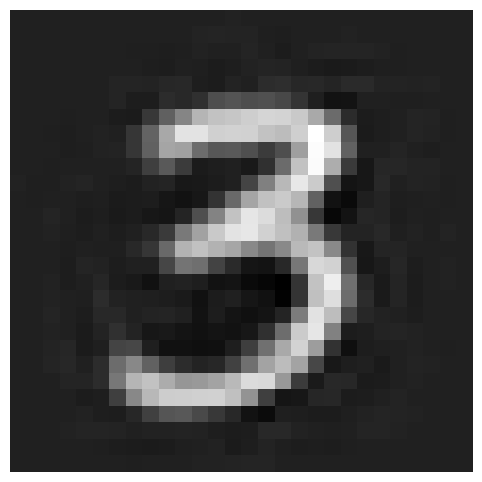

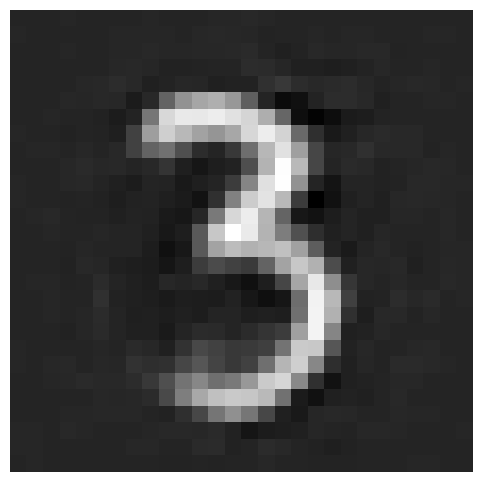

In [1559]:
import matplotlib.pyplot as plt
import numpy as np

def generateInput(samples, number, weight):
    image = np.array([np.random.rand(784) for _ in range(samples)])
    label = np.array([[weight if i == number else 0 for i in range(10)] for _ in range(samples)])
    return [image, label]

input = generateInput(samples=5, number=3, weight=2)
predictions = model.predict(input,verbose=False)

for prediction in predictions:
    fig, axs = plt.subplots(1, 1, figsize=(12, 6), squeeze=False)
    axs[0, 0].imshow(prediction.reshape(28, 28).astype('float'), cmap='gray')
    for ax in axs[0]:
        ax.axis('off')
    plt.show()

## Here is what each layer group is doing

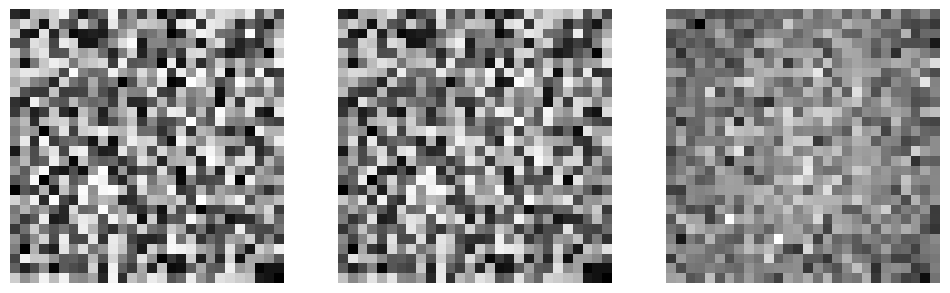

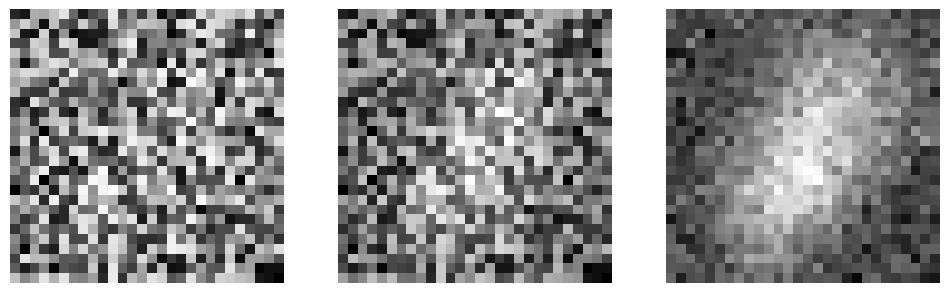

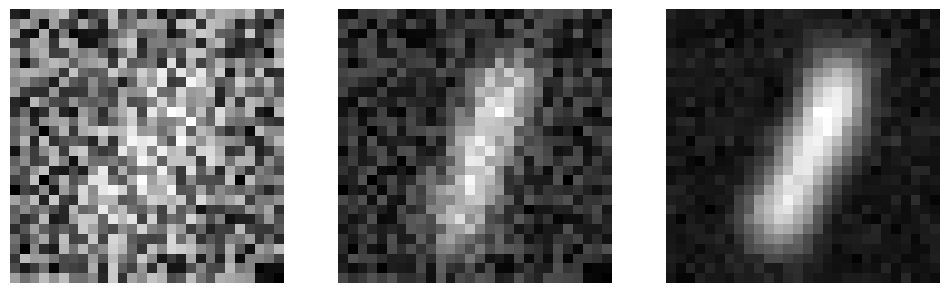

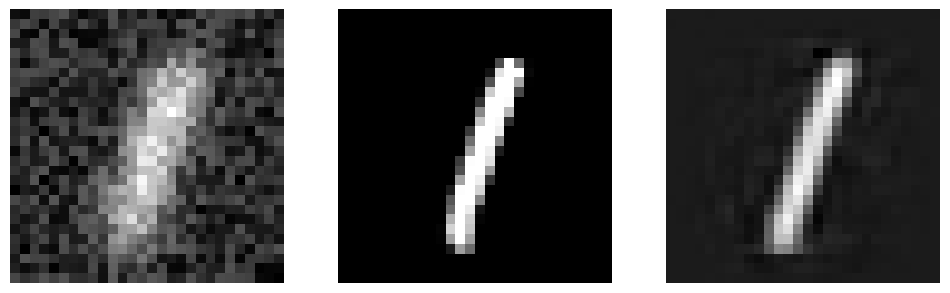

In [1396]:

item = 5
level = 1

for level in range(len(chunks)):
    fig, axs = plt.subplots(1,3, figsize=(12, 6), squeeze=False)
    axs[0, 0].imshow(x_test[level][item].reshape(28,28).astype('float'), cmap='gray')
    axs[0, 1].imshow(y_test[level][item].reshape(28,28).astype('float'), cmap='gray')
    axs[0, 2].imshow(chunks[level].predict([x_test[level], l_test[level]], verbose=False)[item].reshape(28, 28).astype('float'), cmap='gray')
    for ax in axs[0]:
        ax.axis('off')

    plt.show()